- num. Tokens by category
- num. Fragments by category
- Fragment sizes
- Fragment paper types
- Most popular:
    - authorities
    - body parts
    - ailments
    - treatments
    - ingredients
    - Co-occurance of these?

In [1]:
import altair as alt
import pandas as pd

alt.data_transformers.enable('json')

/home/hal/.local/share/virtualenvs/genizah-visualisation-mG8BC0xT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


DataTransformerRegistry.enable('json')

In [2]:
token_types = pd.read_csv('../medical-data/token-types.csv', index_col='token')
token_types.head()

,type
token,
abcess,ailment
abcesses,ailment
abdomen,body_part
abdominal,body_part
abnormal,ailment


In [3]:
fragment_tokens = pd.read_csv('../medical-data/fragment-tokens.csv')
fragment_tokens.head()

,classmark,token
0,MS-OR-01080-00001-00063,pharmacopoeia
1,MS-OR-01080-00001-00063,containing
2,MS-OR-01080-00001-00063,diagram
3,MS-OR-01080-00001-00063,and
4,MS-OR-01080-00001-00063,symbol


In [4]:
len(fragment_tokens)

38165

In [5]:
fragment_tokens = pd.merge(fragment_tokens, token_types, 
                  left_on='token', right_index=True,
                  sort=False, validate='m:1')
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [6]:
fragment_tokens.shape

(8348, 3)

In [7]:
fragments = pd.read_json('../medical-data/genizah-medical.json', orient='index')
fragments.index.name = 'classmark'
fragments = fragments.reset_index()
fragments.head()

,classmark,columns,date_end,date_start,height,lines,material,summary,title,width
0,MS-OR-01080-00001-00063,1.0,1899-12-31,0500-01-01,21.2,21.0,paper,"Pharmacopoeia, containing diagrams and symbols...",Medical,14.3
1,MS-OR-01080-00001-00072,1.0,1899-12-31,0500-01-01,36.4,22.0,vellum,"Discussion of various medical treatments, regi...",Medical,16.8
2,MS-OR-01080-00001-00081,1.0,1899-12-31,0500-01-01,25.4,12.0,paper,"Medical work on the composition of the body, c...",Medical,16.8
3,MS-OR-01080-00001-00087,1.0,1233-12-31,1213-01-01,NaN,5.0,paper,Recto: a short medical recipe. Verso: a respon...,Medical,NaN
4,MS-OR-01080-00002-00070,1.0,1199-12-31,1100-01-01,31.5,35.0,paper,Autograph draft of a medical work by Moses Mai...,Medical,22.8


In [8]:
fragments.shape

(1565, 10)

## Fragment Materials

In [9]:
material_counts = (pd.DataFrame(fragments.groupby('material').size(), columns=['count'])
    .reset_index())
material_counts

,material,count
0,cardboard,1
1,cloth,2
2,paper,1490
3,vellum,71


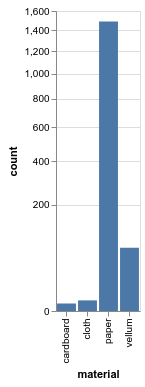

In [10]:
alt.Chart(material_counts).mark_bar().encode(
    alt.X('material:N'),
    y=alt.Y('count:Q', scale=alt.Scale(type='pow', exponent=0.5)),
    tooltip='count'
)

## Fragment Sizes

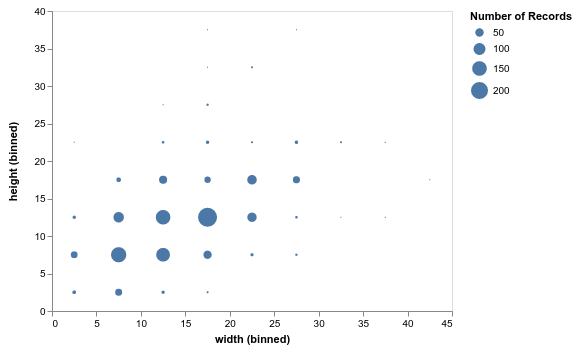

In [11]:
alt.Chart(fragments).mark_circle().encode(
    alt.X('width:Q', bin=True),
    alt.Y('height:Q', bin=True),
    size='count()'
)

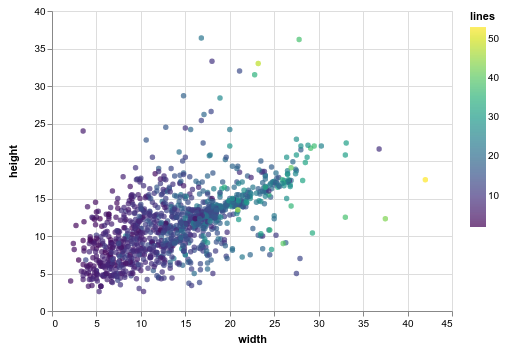

In [12]:
alt.Chart(fragments).mark_circle().encode(
    alt.X('width:Q'),
    alt.Y('height:Q'),
    color=alt.Color('lines:Q', bin=False, scale=alt.Scale(scheme='viridis')),
    tooltip='classmark'
).interactive()

## Tokens

### Token Types

In [13]:
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [14]:
tokens_per_type = (fragment_tokens[['type', 'token']].drop_duplicates()
    .groupby(['type'])
    .count())
fragments_per_type = (fragment_tokens[['type', 'classmark']].drop_duplicates()
    .groupby(['type'])
    .count())

for df in [tokens_per_type, fragments_per_type]:
    df.rename(columns=lambda c: 'count', inplace=True)

tokens_per_type['count_type'] = 'tokens'
fragments_per_type['count_type'] = 'fragments'

token_type_counts = (pd.concat([tokens_per_type, fragments_per_type], sort=False))
token_type_counts

,count,count_type
type,,
ailment,402,tokens
authority,48,tokens
body_part,185,tokens
ingredient,469,tokens
treatment,211,tokens
ailment,799,fragments
authority,329,fragments
body_part,724,fragments
ingredient,564,fragments


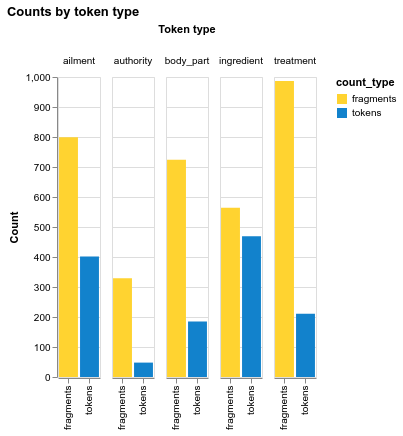

In [15]:
(alt.Chart(token_type_counts.reset_index(), title='Counts by token type')
  .mark_bar()
  .encode(
    alt.Y('count:Q', axis=alt.Axis(title='Count')),
    alt.X('count_type:N', axis=alt.Axis(title=None)),
    column=alt.Column('type:N', title='Token type'),
    color=alt.Color('count_type:N', 
                    scale=alt.Scale(range=["#FFD330", "#1282CC"]))
))

In [16]:
def display_values(field=None, mapping=None, display_field_name=None):
    if display_field_name is None:
        display_field_name = f'{field}_display'
    
    lookup_frame = pd.DataFrame.from_records(list(mapping.items()), columns=[field, display_field_name])
    return alt.LookupData(data=lookup_frame, key=field, fields=[display_field_name])

In [17]:
type_display_tx = display_values('type', {
    'ailment': 'Ailment',
    'authority': 'Authority',
    'body_part': 'Body part',
    'ingredient': 'Ingredient',
    'treatment': 'Treatment'
})
count_type_display_tx = display_values('count_type', {
    'fragments': 'Fragments',
    'tokens': 'Tokens'
})

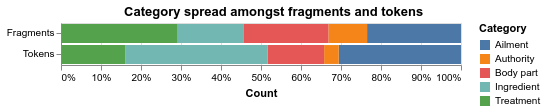

In [18]:
(alt.Chart(token_type_counts.reset_index(), title='Category spread amongst fragments and tokens')
  .mark_bar()
  .encode(
    alt.X('count:Q', axis=alt.Axis(title='Count', format='%'), stack='normalize'),
    alt.Y('count_type_display:N', axis=alt.Axis(title=None)),
    color=alt.Color('type_display:N', title='Category'),
    tooltip=['count:Q']
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
  .transform_lookup(lookup='count_type', from_=count_type_display_tx))

## Token usage frequency

In [19]:
fragments_per_token = (pd.DataFrame(fragment_tokens.groupby('token').size(), 
                                    columns=['count']))
fragments_per_token = fragments_per_token.merge(token_types, left_index=True, right_index=True)
fragments_per_token.sort_values(by='count', ascending=False).head()

,count,type
token,,
treatment,209,treatment
simple,180,ingredient
eye,155,body_part
medicine,150,treatment
disease,142,ailment


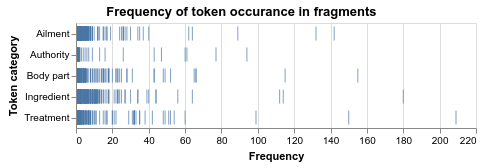

In [20]:
(alt.Chart(fragments_per_token, title='Frequency of token occurance in fragments')
  .mark_tick()
  .encode(
      alt.X('count:Q', title='Frequency'),
      alt.Y('type_display:N', title='Token category')
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
)

In [21]:
vl_json = (alt.Chart(fragments_per_token, title='Frequency of token occurance in fragments')
  .mark_tick()
  .encode(
      alt.X('count:Q', title='Frequency'),
      alt.Y('type_display:N', title='Token category')
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
).to_dict()
vl_json

{'config': {'view': {'width': 400, 'height': 300}},
 'data': {'url': 'altair-data-c5535744356d581da85ba4effaa9bc34.json',
  'format': {'type': 'json'}},
 'mark': 'tick',
 'encoding': {'x': {'type': 'quantitative',
   'field': 'count',
   'title': 'Frequency'},
  'y': {'type': 'nominal',
   'field': 'type_display',
   'title': 'Token category'}},
 'title': 'Frequency of token occurance in fragments',
 'transform': [{'lookup': 'type',
   'from': {'data': {'url': 'altair-data-d32954b3094189bc656919d404cecdd7.json',
     'format': {'type': 'json'}},
    'key': 'type',
    'fields': ['type_display']}}],
 '$schema': 'https://vega.github.io/schema/vega-lite/v2.4.3.json'}

In [22]:
import altair.vega.v3
import altair.vega.v2

In [25]:
vega_wordcloud_json = {
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "width": 800,
  "height": 400,
  "padding": 0,

  "data": [
    {
      "name": "table",
      "values": [
        "Declarative visualization grammars can accelerate development, facilitate retargeting across platforms, and allow language-level optimizations. However, existing declarative visualization languages are primarily concerned with visual encoding, and rely on imperative event handlers for interactive behaviors. In response, we introduce a model of declarative interaction design for data visualizations. Adopting methods from reactive programming, we model low-level events as composable data streams from which we form higher-level semantic signals. Signals feed predicates and scale inversions, which allow us to generalize interactive selections at the level of item geometry (pixels) into interactive queries over the data domain. Production rules then use these queries to manipulate the visualization’s appearance. To facilitate reuse and sharing, these constructs can be encapsulated as named interactors: standalone, purely declarative specifications of interaction techniques. We assess our model’s feasibility and expressivity by instantiating it with extensions to the Vega visualization grammar. Through a diverse range of examples, we demonstrate coverage over an established taxonomy of visualization interaction techniques.",
        "We present Reactive Vega, a system architecture that provides the first robust and comprehensive treatment of declarative visual and interaction design for data visualization. Starting from a single declarative specification, Reactive Vega constructs a dataflow graph in which input data, scene graph elements, and interaction events are all treated as first-class streaming data sources. To support expressive interactive visualizations that may involve time-varying scalar, relational, or hierarchical data, Reactive Vega’s dataflow graph can dynamically re-write itself at runtime by extending or pruning branches in a data-driven fashion. We discuss both compile- and run-time optimizations applied within Reactive Vega, and share the results of benchmark studies that indicate superior interactive performance to both D3 and the original, non-reactive Vega system.",
        "We present Vega-Lite, a high-level grammar that enables rapid specification of interactive data visualizations. Vega-Lite combines a traditional grammar of graphics, providing visual encoding rules and a composition algebra for layered and multi-view displays, with a novel grammar of interaction. Users specify interactive semantics by composing selections. In Vega-Lite, a selection is an abstraction that defines input event processing, points of interest, and a predicate function for inclusion testing. Selections parameterize visual encodings by serving as input data, defining scale extents, or by driving conditional logic. The Vega-Lite compiler automatically synthesizes requisite data flow and event handling logic, which users can override for further customization. In contrast to existing reactive specifications, Vega-Lite selections decompose an interaction design into concise, enumerable semantic units. We evaluate Vega-Lite through a range of examples, demonstrating succinct specification of both customized interaction methods and common techniques such as panning, zooming, and linked selection."
      ],
      "transform": [
        {
          "type": "countpattern",
          "field": "data",
          "case": "upper",
          "pattern": "[\\w']{3,}",
          "stopwords": "(i|me|my|myself|we|us|our|ours|ourselves|you|your|yours|yourself|yourselves|he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves|what|which|who|whom|whose|this|that|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|will|would|should|can|could|ought|i'm|you're|he's|she's|it's|we're|they're|i've|you've|we've|they've|i'd|you'd|he'd|she'd|we'd|they'd|i'll|you'll|he'll|she'll|we'll|they'll|isn't|aren't|wasn't|weren't|hasn't|haven't|hadn't|doesn't|don't|didn't|won't|wouldn't|shan't|shouldn't|can't|cannot|couldn't|mustn't|let's|that's|who's|what's|here's|there's|when's|where's|why's|how's|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|upon|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|say|says|said|shall)"
        },
        {
          "type": "formula", "as": "angle",
          "expr": "[-45, 0, 45][~~(random() * 3)]"
        },
        {
          "type": "formula", "as": "weight",
          "expr": "if(datum.text=='VEGA', 600, 300)"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#d5a928", "#652c90", "#939597"]
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "text"}
        },
        "update": {
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.5}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [800, 400],
          "text": {"field": "text"},
          "rotate": {"field": "datum.angle"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.count"},
          "fontWeight": {"field": "datum.weight"},
          "fontSizeRange": [12, 56],
          "padding": 2
        }
      ]
    }
  ]
}
alt.vega.v3.vega(vega_wordcloud_json)

<Vega 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [24]:
print(alt.renderers.active)

default
